# Time Series Analysis- GARCH Model

Author: Yvonne Hsu

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
from datetime import date, timedelta, datetime
from time import time
import seaborn as sns
sns.set()
import yfinance as yf
import pmdarima as pmd
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from arch import arch_model
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

## Load data & Preprocessing

Take Apple for target stock, and choose 2020 to 2024 August for model.

In [2]:
symbol = 'AAPL'

In [3]:
ticker = yf.Ticker(symbol)

In [4]:
hist = ticker.history(start = '2020-01-01',end = '2024-08-31', interval='1d').Close
hist = hist.reset_index()
#cast datetime to date
#hist.Date = hist.Date.apply(lambda d: d.date())
hist =  pd.DataFrame(hist)
hist = hist.set_index('Date')

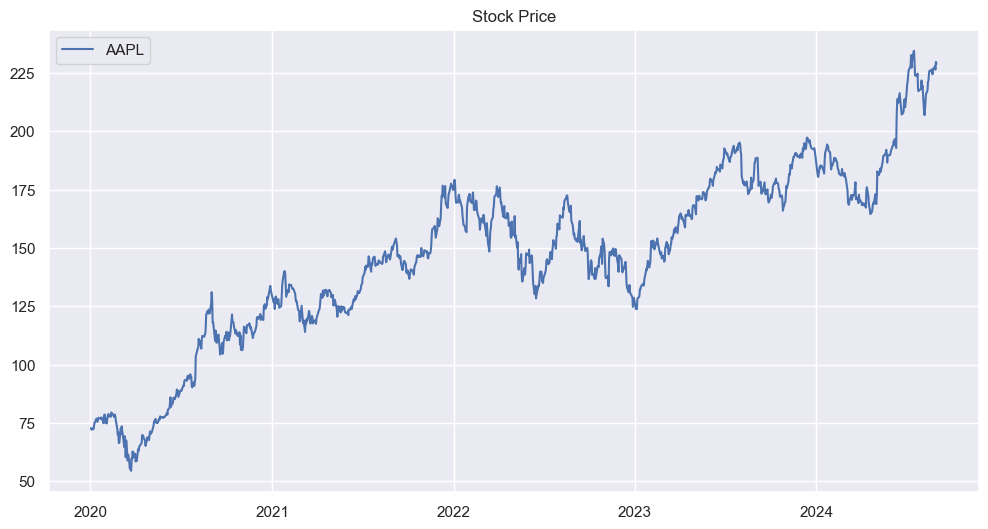

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(hist.Close, label = f'{symbol}')
plt.title('Stock Price')
plt.legend()

The plot clearly shows an overall upward trend from 2020 to 2024.
A stationary time series should have three components:
- Constant Mean: But here we can see the average price increasing over the years.
- Constant Volatility: The volatility (variation in price) appears to change over time. For example, there seems to be more significant price swings in the latter part of the graph compared to earlier periods. A stationary series should have constant variance.
- Seasonality: Not as obvious as the trend.

Therefore, this stock is not stationary.

### Using the Augmented Dickey-Fuller (ADF) test to scientifically validate the non-stationarity

In [6]:
from statsmodels.tsa.stattools import adfuller

price_p_value = adfuller(hist.Close)[1]
print(f'{symbol} ADF-P:', '{:.5f}'.format(price_p_value))
if price_p_value > 0.05:
    print('Nonstationary')
else:
    print('Stationary')

AAPL ADF-P: 0.74330
Nonstationary


- H_0: The time series has a unit root (is non-stationary)
- H_1: The time series is stationary

Since the p-value (0.74330) is greater than 0.05, we fail to reject the null hypothesis. This provides statistical evidence that the time series is not stationary.

In [7]:
hist_temp = ticker.history(start = '2018-12-31',end = '2024-08-31', interval='1d').Close
hist_temp =  pd.DataFrame(hist_temp)
daily_return = hist_temp.Close.pct_change()*100
hist = hist.join(daily_return.rename('daily_return'))
hist = hist.dropna()

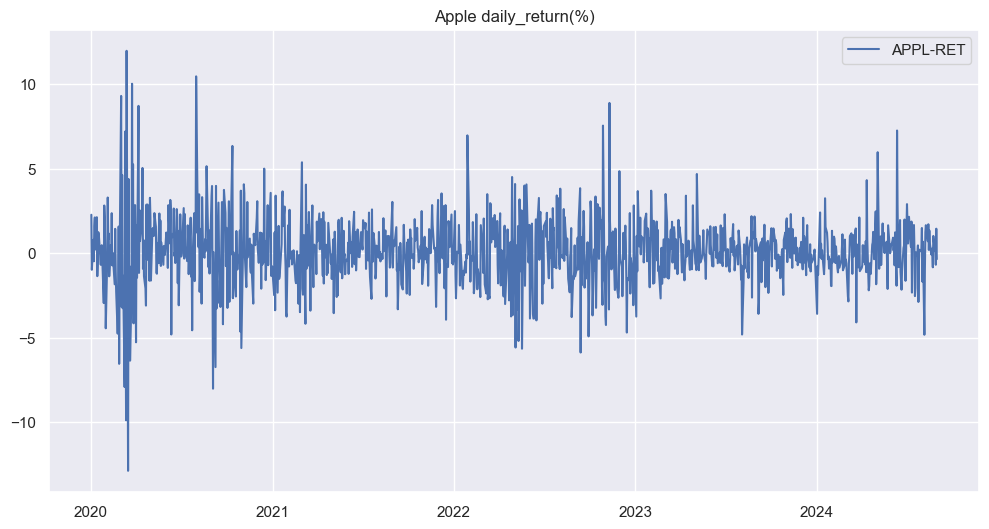

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(hist['daily_return'], label = 'APPL-RET')
plt.title('Apple daily_return(%)')
plt.legend()

In [9]:
price_p_value = adfuller(hist.daily_return)[1]
print(f'{symbol} ADF-P:', '{:.5f}'.format(price_p_value))
if price_p_value > 0.05:
    print('Nonstationary')
else:
    print('Stationary')

AAPL ADF-P: 0.00000
Stationary


Returns are more likely to be stationary compared to raw price data. Price series often exhibit trends and non-constant variance, while returns tend to fluctuate around a constant mean with more consistent variance.
The ADF hypothesis test shows that the returns of Apple is stationary.

Split data into training and testing dataset. As we are aim to predict the future stock price, we use the date before 2024 as training to predict 2024 performance.

### Prepare training and teseting data

In [10]:
train_date = hist.index.get_level_values('Date') < '2024-01-01'
train_data = hist[train_date]
test_data = hist[~train_date]

## ARIMA Model

In [11]:
pmd_mdl = pmd.auto_arima(train_data['daily_return'], stationary = True)
pmd_mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1006
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -2171.270
Date:                Sun, 29 Sep 2024   AIC                           4348.540
Time:                        18:19:03   BIC                           4363.282
Sample:                             0   HQIC                          4354.141
                               - 1006                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1367      0.066      2.069      0.039       0.007       0.266
ar.L1         -0.1336      0.020     -6.732      0.000      -0.173      -0.095
sigma2         4.3875      0.119     36.922      0.000       4.155       4.620
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               697.51
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.40   Skew:                             0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
model = ARIMA(train_data['daily_return'], order = (1, 0, 0))
stats_mdl = model.fit() 
print(stats_mdl.summary())

                               SARIMAX Results                                
Dep. Variable:           daily_return   No. Observations:                 1006
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2171.270
Date:                Sun, 29 Sep 2024   AIC                           4348.540
Time:                        18:19:03   BIC                           4363.282
Sample:                             0   HQIC                          4354.141
                               - 1006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1206      0.058      2.066      0.039       0.006       0.235
ar.L1         -0.1336      0.020     -6.732      0.000      -0.173      -0.095
sigma2         4.3875      0.119     36.922      0.0

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


This is a SARIMAX(1, 0, 0) model. The (1, 0, 0) indicates:

- 1: First-order autoregressive term (AR)
- 0: No differencing
- 0: No moving average terms

- AR(1) Coefficient:
The ar.L1 coefficient (autoregressive lag 1) is -0.1336. For every 1 unit increase in the previous period's value, the current period's value is expected to decrease by 0.1336 units, on average, holding other factors constant.

-The model captures some of the time series dynamics, but the non-normality and heteroskedasticity(not above 5) in residuals suggest there might be room for improvement, possibly by considering GARCH-type models or additional explanatory variables.

### Residual Diagnosis 

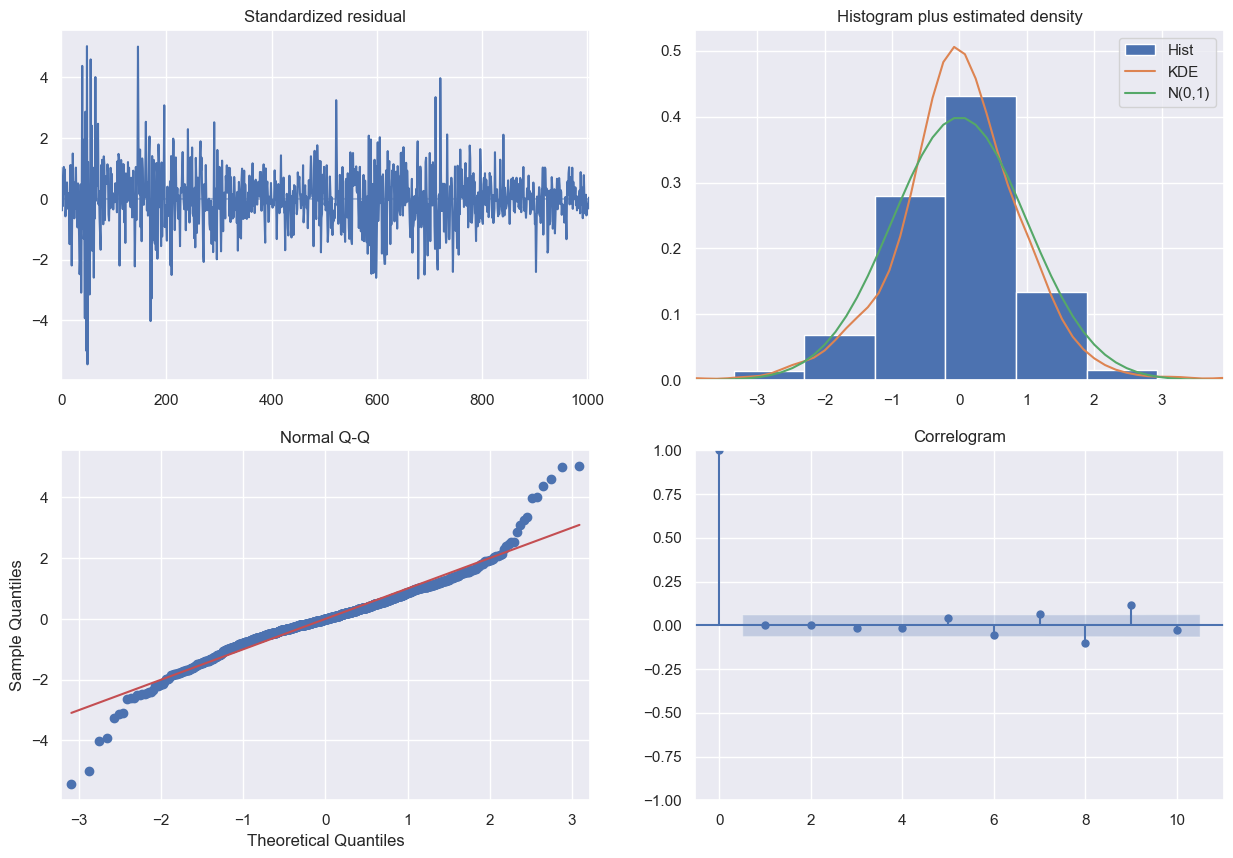

In [13]:
pmd_mdl.plot_diagnostics(figsize = (15, 10))
plt.show()

1. Standardized Residual Plot (Top Left):
This plot shows the standardized residuals over time. The residuals appear to be centered around zero without any obvious trend, which is good. However, there are some notable spikes, indicating periods of higher volatility. This suggests that while the model captures the overall pattern, it may not fully account for all the volatility in the data.

2. Histogram plus Estimated Density (Top Right):
This plot compares the distribution of residuals to a normal distribution. The residuals exhibit a narrow peak and fat tails phenomenon. This means the tails are heavier, indicating more extreme values than expected in a normal distribution.

3. Normal Q-Q Plot (Bottom Left):
This plot compares the quantiles of the residuals against theoretical quantiles of a normal distribution. The S-shaped curve, deviating from the straight line, especially at the tails, confirms that the model residuals lack sufficient normality. This reinforces the conclusion from the top right histogram.

4. Correlogram (Bottom Right):
This shows the autocorrelation of residuals at different lags. Most correlations are close to zero and within the confidence bands (blue shaded area), which is good. It suggests that the model has captured most of the time-dependent structure in the data.

### Ljung-Box test- White Noise Test

Next step, we use statistical way to validate our residual test. 

Using the Ljung-Box test to observe whether the residual terms of the ARIMA model are randomly fluctuating. If the test results show white noise (randomness), then we can know that the ARIMA model's fit is good, and we can proceed directly to prediction. However, if the test results show that the error terms are not white noise, then we need to use a GARCH model to find the variance explanatory variables within the error terms.

In [14]:
arima_resid = stats_mdl.resid

white_noise_arima = acorr_ljungbox(arima_resid, lags = [10], return_df=True)
white_noise_arima

,lb_stat,lb_pvalue
10,34.026107,0.000183


- H_0: The residuals are white noise.
- H_1: The residuals are not white noise.
  
The very small p-value (0.000183 < 0.05) indicates strong evidence against the null hypothesis of no autocorrelation.

## GARCH MODEL

GARCH (Generalized Autoregressive Conditional Heteroskedasticity) models are specifically designed to model and forecast heteroskedastic variance in time series data.
These models are most useful when heteroskedasticity is present in the data.

### ARCH Effect Test

In [15]:
# Use ARCH LM test
LM_pvalue = het_arch(arima_resid, ddof = 4)[1]
print('LM-test-Pvalue:', '{:.5f}'.format(LM_pvalue))

LM-test-Pvalue: 0.00000


- H_0: The residuals have ARCH Effect
- H_1: The residuals do not have ARCH Effect
- 
- Based on the extremely low p-value (0.00000) from the ARCH LM test, we can conclusively reject the null hypothesis of no ARCH effects. This result strongly indicates the presence of heteroskedasticity in the time series data, confirming that a GARCH-type model would be appropriate for capturing the changing volatility structure. Now, we are ready to go.

By observing the residual ACF/PACF plots, we can understand the lag patterns of the squared residual terms, and incorporate these observed results into the GARCH model to determine the parameter combination for the GARCH model and test the volatility.

- Autocorrelation Function (ACF): Measures the degree of correlation between different values within a selected period of a time series.
- Partial Autocorrelation Function (PACF): Measures the correlation between corresponding values in selected time series intervals, while controlling for the effects of intermediate lags.


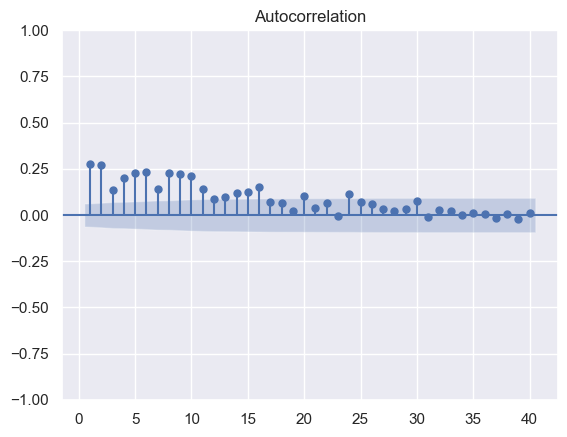

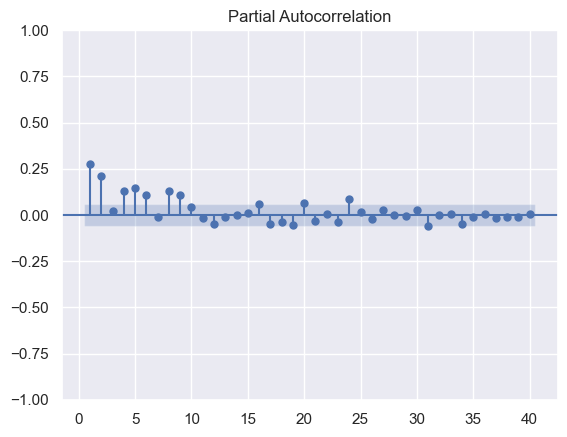

In [16]:
acf_plot = plot_acf(arima_resid**2, zero = False, lags = 40)
pacf_plot = plot_pacf(arima_resid**2, zero = False, lags = 40)

PACF and ACF plots show multiple spikes. The PACF plot indicates pronounced first and second lags. Considering this and the GARCH model structure, we assume parameter combinations (p,q) of (1,1), (2,1), (1,2), and (2,2). We then use grid search to evaluate model fit and coefficient significance for each combination before selecting the best one.

In [17]:
# Define the parameter grid
p_values = [1, 2]
q_values = [1, 2]

# Create a list to store results
results = []

# Perform grid search
for p in p_values:
    for q in q_values:
        model = arch_model(arima_resid, vol='GARCH', p=p, q=q)
        result = model.fit(disp='off')
        
        # Store the results
        results.append({
            'p': p,
            'q': q,
            'aic': result.aic,
            'bic': result.bic,
            'log_likelihood': result.loglikelihood
        })

# Convert results to a DataFrame for easy viewing
results_df = pd.DataFrame(results)

# Sort by AIC (you can change this to BIC if preferred)
best_model = results_df.sort_values('aic').iloc[0]

print("Grid search results:")
print(results_df)
print("\nBest model:")
print(best_model)

Grid search results:
   p  q          aic          bic  log_likelihood
0  1  1  4122.785327  4142.440276    -2057.392663
1  1  2  4124.785326  4149.354013    -2057.392663
2  2  1  4124.658014  4149.226701    -2057.329007
3  2  2  4123.116584  4152.599008    -2055.558292

Best model:
p                    1.000000
q                    1.000000
aic               4122.785327
bic               4142.440276
log_likelihood   -2057.392663
Name: 0, dtype: float64


Grid Search for the best combination of garch model
All combinations have very similar results, it might indicate that the GARCH model is stable across different specifications. This could mean that the volatility in the time series is well-captured by even the simplest model (GARCH(1,1)), and adding more lags doesn't significantly improve the fit. So here we choose p,q=1

In [18]:
#estimating the model parameters. The scale of y is 0.0004388.
#Parameter estimation work better when this value is between 1 and 1000. The recommended

mdl_garch = arch_model(arima_resid, vol = 'GARCH', p = 1, q = 1)
garch_fit = mdl_garch.fit()
garch_fit.summary()
print(garch_fit.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 5568.587418261592
Iteration:      2,   Func. Count:     15,   Neg. LLF: 120668332150.35243
Iteration:      3,   Func. Count:     23,   Neg. LLF: 2455.2929448263512
Iteration:      4,   Func. Count:     30,   Neg. LLF: 2059.4389380188595
Iteration:      5,   Func. Count:     36,   Neg. LLF: 3160.7114990063715
Iteration:      6,   Func. Count:     43,   Neg. LLF: 2057.392663466501
Iteration:      7,   Func. Count:     47,   Neg. LLF: 2057.392663466054
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2057.392663466501
            Iterations: 7
            Function evaluations: 47
            Gradient evaluations: 7
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Like

This time the model performs robust.
GARCH addresses the heteroskedasticity hinted at by the ARIMA model's warnings. GARCH has a higher log-likelihood (-2057.39 vs -2653.131), indicating better fit.

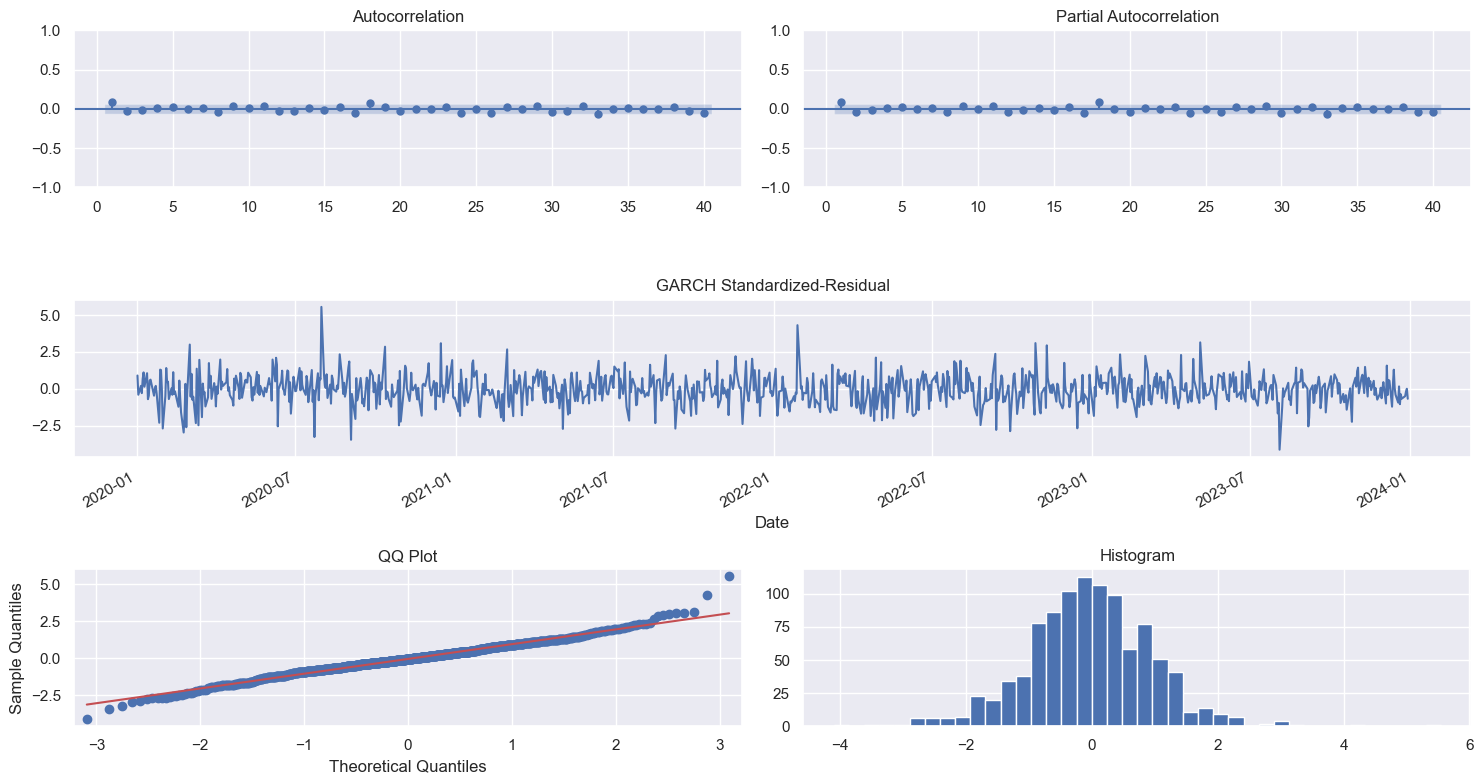

In [19]:
import statsmodels.api as sm
#Manually plot
garch_std_resid = pd.Series(garch_fit.resid / garch_fit.conditional_volatility)
fig = plt.figure(figsize = (15, 8))

# Residual
garch_std_resid.plot(ax = fig.add_subplot(3,1,2), title = 'GARCH Standardized-Residual', legend = False)

# ACF/PACF
garch_plot_acf= plot_acf(garch_std_resid, zero = False, lags = 40, ax=fig.add_subplot(3,2,1))
garch_plot_pacf= plot_pacf(garch_std_resid, zero = False, lags = 40, ax=fig.add_subplot(3,2,2))

# QQ-Plot & Norm-Dist
sm.qqplot(garch_std_resid, line='s', ax=fig.add_subplot(3,2,5)) 
plt.title("QQ Plot")
fig.add_subplot(3,2,6).hist(garch_std_resid, bins = 40)
plt.title("Histogram")

plt.tight_layout()
plt.show()

1. ACF and PACF plots:
Both the autocorrelation and partial autocorrelation plots show very little significant correlation at any lag. This is a good sign, indicating that the GARCH model has successfully captured most of the temporal dependencies in the volatility of the time series.

2. GARCH Standardized-Residual plot:
The standardized residuals appear to fluctuate around zero with relatively constant variance over time. There are no obvious patterns or trends visible, which suggests that the GARCH model has captured most of the volatility clustering in the original data.

3. Normal Q-Q Plot (Bottom Left):
The QQ plot shows that the standardized residuals closely follow a normal distribution for most of the range. There is a few deviation at the extreme tails, particularly for very large positive values, indicating that the model might slightly underestimate the probability of extreme events.

4. Correlogram (Bottom Right):
The histogram of standardized residuals appears roughly bell-shaped and symmetric, which is consistent with the assumption of normally distributed errors in the GARCH model. There might be slightly heavier tails than a perfect normal distribution, which aligns with the observation from the QQ plot.

### Ljung-Box test-mm White Noise Test

In [20]:
white_noise_garch = acorr_ljungbox(garch_std_resid, lags = [10], return_df=True)
white_noise_garch

,lb_stat,lb_pvalue
10,12.45547,0.255729


- H_0: The residuals are white noise.
- H_1: The residuals are not white noise.
  
The p-value (0.2557 > 0.05) suggests that we fail to reject the null hypothesis of not white noise.
Therefore, it indicates that no other explanatory variables can be extracted from the residuals, and they are already a random process.

## So the AIRMA-GARCH(1,0,0)(1,1) model is:

## $\hat{y_t} = 0.0997 - 0.0952y_{t-1} + \varepsilon_t$

## Forecasting

Here we predict for both training and testing data.

In [21]:
mu = stats_mdl.predict(start = 0, end = len(train_data)-1)
forecast_mu= stats_mdl.predict(start = len(train_data), end = len(hist)-1)

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


/var/folders/h6/klvb6_m549910x127srrt7040000gn/T/ipykernel_99137/1943745480.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['predict_daily_return'] = mu.values


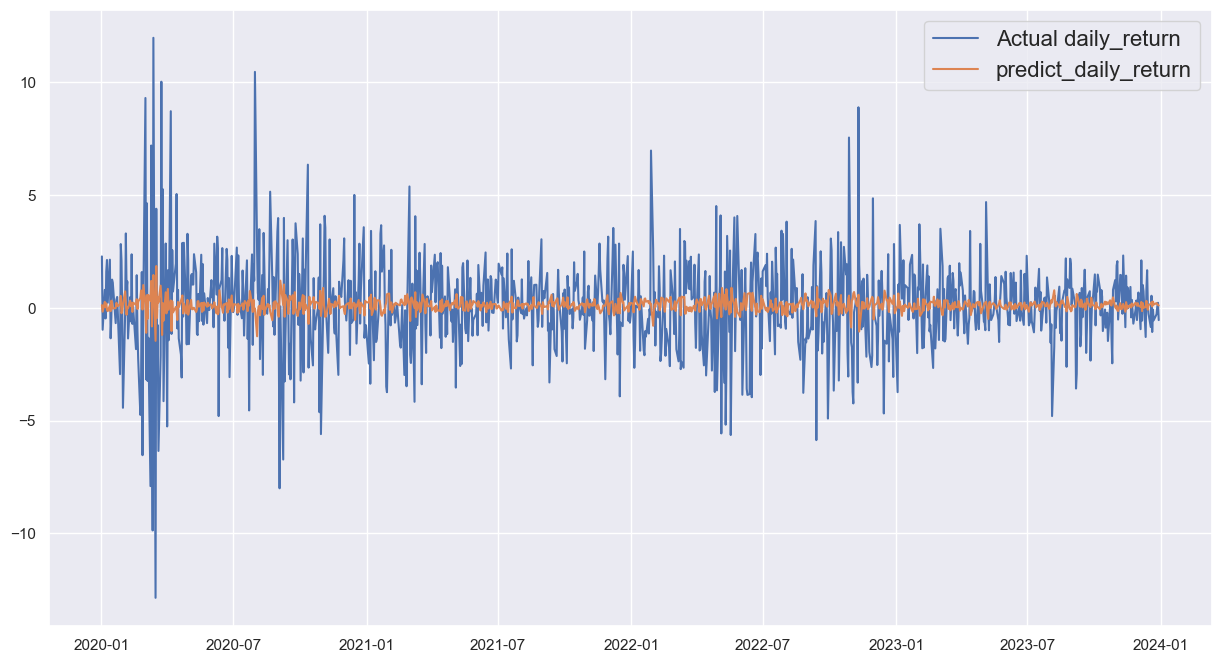

In [22]:
train_data['predict_daily_return'] = mu.values


plt.figure(figsize=(15,8))

plt.plot(train_data['daily_return'])
plt.plot(train_data['predict_daily_return'])

plt.legend(('Actual daily_return', 'predict_daily_return'), fontsize=16)

/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/volatility.py:1201: RuntimeWarning: invalid value encountered in scalar divide
  scale = np.mean(resids**2) / (target ** (2.0 / power))
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/distribution.py:451: RuntimeWarning: divide by zero encountered in log
  lls = -0.5 * (log(2 * pi) + log(sigma2) + resids ** 2.0 / sigma2)
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/distribution.py:451: RuntimeWarning: invalid value encountered in divide
  lls = -0.5 * (log(2 * pi) + log(sigma2) + resids ** 2.0 / sigma2)
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/distribution.py:451: RuntimeWarning: divide by zero encountered in divide
  lls = -0.5 * (log(2 * pi) + log(sigma2) + resids ** 2.0 / sigma2)
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/distribution.py:451: RuntimeWarning: invalid value encountered in add
  lls = -0.5 * (log(2 * pi) + log(sigma2) + resids ** 2.0 / sigma2)
/opt

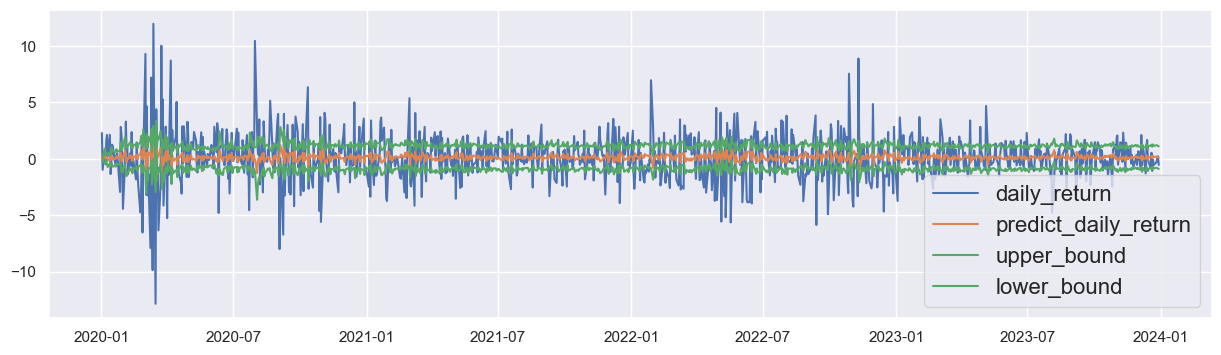

In [23]:
garch_forecast = [np.nan]  # Start with an initial NaN value to match the length of train_data

for i in range(1, len(train_data)):
    train = garch_std_resid[:i]
    model = arch_model(train, vol='GARCH', p=1, q=1)
    garch_fit = model.fit(disp="off")  # Suppress output
    prediction = garch_fit.forecast(horizon=1)
    garch_forecast.append(np.sqrt(prediction.variance.values[-1:][0]))

# Add the forecasts to the dataframe
train_data['GARCH_predicted_volatility'] = garch_forecast

# Assuming test_data['predict_daily_return'] is available and aligns with train_data
train_data['upper_bound'] = train_data['predict_daily_return'] + train_data['GARCH_predicted_volatility']
train_data['lower_bound'] = train_data['predict_daily_return'] - train_data['GARCH_predicted_volatility']

# Plot the results
plt.figure(figsize=(15, 4))
plt.plot(train_data['daily_return'])
plt.plot(train_data['predict_daily_return'])
plt.plot(train_data['upper_bound'], color='g')
plt.plot(train_data['lower_bound'], color='g')

plt.legend(('daily_return', 'predict_daily_return', 'upper_bound', 'lower_bound'), fontsize=16)
plt.show()

/var/folders/h6/klvb6_m549910x127srrt7040000gn/T/ipykernel_99137/393874917.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predict_daily_return'] = forecast_mu.values


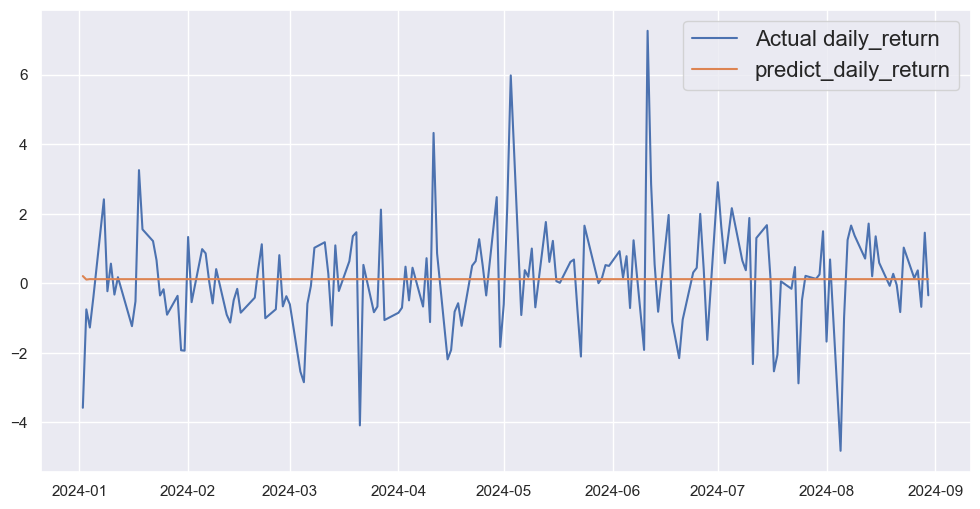

In [24]:
test_data['predict_daily_return'] = forecast_mu.values


plt.figure(figsize=(12,6))

plt.plot(test_data['daily_return'])
plt.plot(test_data['predict_daily_return'])

plt.legend(('Actual daily_return', 'predict_daily_return'), fontsize=16)

From the above graph, we observe that after a period of time, the predicted average return gradually becomes a constant approaching zero, with noticeable fluctuations only in the initial stage of the prediction.

### Using the Rolling Forecast for GARCH

Fits a GARCH model to all available data up to that point.
Makes a one-step-ahead forecast of volatility.

In [25]:
garch_forecast = [np.nan] 
for i in range(1,len(train_data)):
    train = garch_std_resid[:i]
    model = arch_model(train, vol = 'GARCH', p = 1, q = 1)
    garch_fit = model.fit()
    prediction = garch_fit.forecast(horizon=1)
    garch_forecast.append(np.sqrt(prediction.variance.values[-1:][0]))


/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/volatility.py:1201: RuntimeWarning: invalid value encountered in scalar divide
  scale = np.mean(resids**2) / (target ** (2.0 / power))
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/distribution.py:451: RuntimeWarning: divide by zero encountered in log
  lls = -0.5 * (log(2 * pi) + log(sigma2) + resids ** 2.0 / sigma2)
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/distribution.py:451: RuntimeWarning: invalid value encountered in divide
  lls = -0.5 * (log(2 * pi) + log(sigma2) + resids ** 2.0 / sigma2)
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/distribution.py:451: RuntimeWarning: divide by zero encountered in divide
  lls = -0.5 * (log(2 * pi) + log(sigma2) + resids ** 2.0 / sigma2)
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/distribution.py:451: RuntimeWarning: invalid value encountered in add
  lls = -0.5 * (log(2 * pi) + log(sigma2) + resids ** 2.0 / sigma2)
/opt

Iteration:      1,   Func. Count:      4,   Neg. LLF: nan
Inequality constraints incompatible    (Exit mode 4)
            Current function value: nan
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1.9700143497729368
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.9700143497729365
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: 15.358582588797432
Iteration:      2,   Func. Count:     12,   Neg. LLF: 2.3958033381773634
Iteration:      3,   Func. Count:     18,   Neg. LLF: 2.2556674907219127
Iteration:      4,   Func. Count:     23,   Neg. LLF: 2.2507287170798937
Iteration:      5,   Func. Count:     29,   Neg. LLF: 2.242733536479474
Iteration:      6,   Func. Count:     34,   Neg. LLF: 2.242732549618193
Optimization terminated successfull

/var/folders/h6/klvb6_m549910x127srrt7040000gn/T/ipykernel_99137/1227545075.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['GARCH_predicted_volatility'] = garch_forecast
/var/folders/h6/klvb6_m549910x127srrt7040000gn/T/ipykernel_99137/1227545075.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['upper_bound'] = train_data['predict_daily_return'] + train_data['GARCH_predicted_volatility']
/var/folders/h6/klvb6_m549910x127srrt7040000gn/T/ipykernel_99137/1227545075.py:6: SettingWit

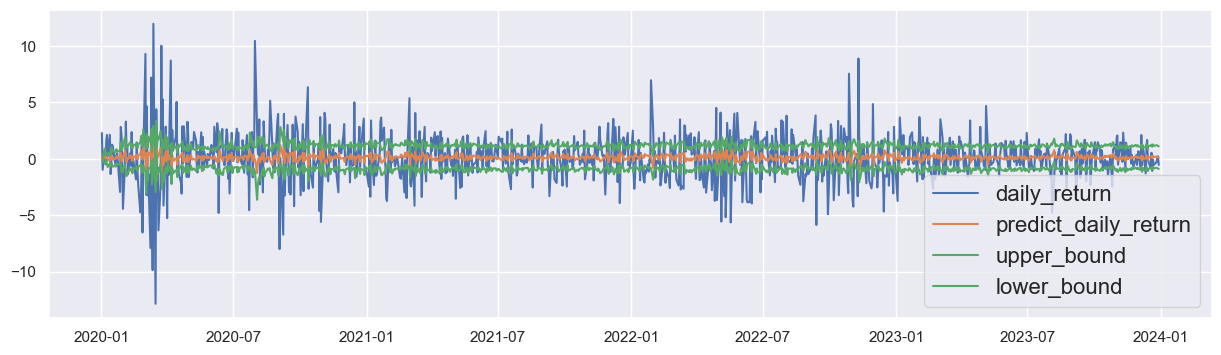

In [26]:
# Add the forecasts to the dataframe
train_data['GARCH_predicted_volatility'] = garch_forecast

# Assuming test_data['predict_daily_return'] is available and aligns with train_data
train_data['upper_bound'] = train_data['predict_daily_return'] + train_data['GARCH_predicted_volatility']
train_data['lower_bound'] = train_data['predict_daily_return'] - train_data['GARCH_predicted_volatility']

# Plot the results
plt.figure(figsize=(15, 4))
plt.plot(train_data['daily_return'])
plt.plot(train_data['predict_daily_return'])
plt.plot(train_data['upper_bound'], color='g')
plt.plot(train_data['lower_bound'], color='g')

plt.legend(('daily_return', 'predict_daily_return', 'upper_bound', 'lower_bound'), fontsize=16)
plt.show()

### Using the Rolling Forecast for GARCH

In [27]:
garch_forecast = []

for i in range(len(test_data)):
    train = arima_resid[:-(len(test_data)-i)]
    model = arch_model(train, vol = 'GARCH', p = 1, q = 1)
    garch_fit = model.fit()
    prediction = garch_fit.forecast(horizon=1)
    garch_forecast.append(np.sqrt(prediction.variance.values[-1:][0]))

Iteration:      1,   Func. Count:      6,   Neg. LLF: 4845.269912032962
Iteration:      2,   Func. Count:     16,   Neg. LLF: 117377.63600102157
Iteration:      3,   Func. Count:     24,   Neg. LLF: 2029.2504244237573
Iteration:      4,   Func. Count:     31,   Neg. LLF: 2013.8997836192143
Iteration:      5,   Func. Count:     38,   Neg. LLF: 1784.046219027211
Iteration:      6,   Func. Count:     43,   Neg. LLF: 1784.0394169525246
Iteration:      7,   Func. Count:     48,   Neg. LLF: 1784.0392298654228
Iteration:      8,   Func. Count:     53,   Neg. LLF: 1784.039210369779
Iteration:      9,   Func. Count:     58,   Neg. LLF: 1784.039209290846
Iteration:     10,   Func. Count:     62,   Neg. LLF: 1784.0392092909005
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1784.039209290846
            Iterations: 10
            Function evaluations: 62
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF: 4850.898560

In [28]:
test_data['GARCH_predicted_volatity'] = (garch_forecast)
test_data['upper_bound'] = test_data['predict_daily_return'] + test_data['GARCH_predicted_volatity']
test_data['lower_bound'] = test_data['predict_daily_return'] - test_data['GARCH_predicted_volatity']

/var/folders/h6/klvb6_m549910x127srrt7040000gn/T/ipykernel_99137/536215975.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['GARCH_predicted_volatity'] = (garch_forecast)
/var/folders/h6/klvb6_m549910x127srrt7040000gn/T/ipykernel_99137/536215975.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['upper_bound'] = test_data['predict_daily_return'] + test_data['GARCH_predicted_volatity']
/var/folders/h6/klvb6_m549910x127srrt7040000gn/T/ipykernel_99137/536215975.py:3: SettingWithCopyWarn

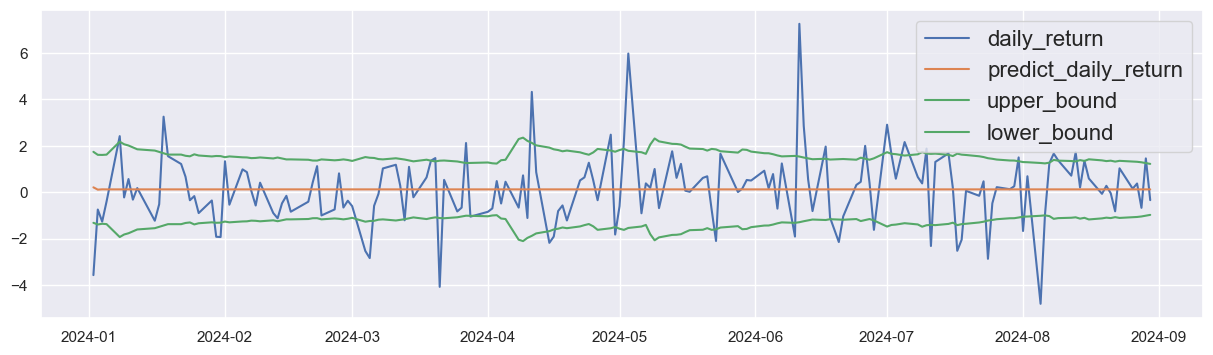

In [29]:
plt.figure(figsize=(15,4))

plt.plot(test_data['daily_return'])
plt.plot(test_data['predict_daily_return'])
plt.plot(test_data['upper_bound'], color = 'g')
plt.plot(test_data['lower_bound'], color = 'g')


plt.legend(('daily_return', 'predict_daily_return', 'upper_bound', 'lower_bound'), fontsize=16)

Most of the actual returns fall within the predicted interval; however, the model is unable to effectively predict returns with larger volatility on individual dates.

### Predict Price

In [30]:
first_price = test_data['Close'][0] / (1+test_data['predict_daily_return'][0]*0.01)

/var/folders/h6/klvb6_m549910x127srrt7040000gn/T/ipykernel_99137/2842490441.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_price = test_data['Close'][0] / (1+test_data['predict_daily_return'][0]*0.01)


In [31]:
test_data['preidct'] = first_price * (1 + test_data['predict_daily_return']*0.01)
test_data['predict_upper'] = first_price * (1 + test_data['upper_bound']*0.01)
test_data['predict_lower'] = first_price * (1 + test_data['lower_bound']*0.01)

/var/folders/h6/klvb6_m549910x127srrt7040000gn/T/ipykernel_99137/1763275517.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['preidct'] = first_price * (1 + test_data['predict_daily_return']*0.01)
/var/folders/h6/klvb6_m549910x127srrt7040000gn/T/ipykernel_99137/1763275517.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predict_upper'] = first_price * (1 + test_data['upper_bound']*0.01)
/var/folders/h6/klvb6_m549910x127srrt7040000gn/T/ipykernel_99137/1763275517.py:3: SettingWithCo

In [32]:
for i in range(1, len(test_data)):
    test_data['preidct'][i] = test_data['preidct'][i-1] * (1 + test_data['predict_daily_return'][i]*0.01)
    test_data['predict_upper'][i] = test_data['predict_upper'][i-1] * (1 + test_data['upper_bound'][i]*0.01)
    test_data['predict_lower'][i] = test_data['predict_lower'][i-1] * (1 + test_data['lower_bound'][i]*0.01)    


/var/folders/h6/klvb6_m549910x127srrt7040000gn/T/ipykernel_99137/893006348.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data['preidct'][i] = test_data['preidct'][i-1] * (1 + test_data['predict_daily_return'][i]*0.01)
/var/folders/h6/klvb6_m549910x127srrt7040000gn/T/ipykernel_99137/893006348.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_in

In [36]:
test_data['avg_predict'] = (test_data['predict_upper'] + test_data['predict_lower']) / 2


/var/folders/h6/klvb6_m549910x127srrt7040000gn/T/ipykernel_99137/3205449756.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['avg_predict'] = (test_data['predict_upper'] + test_data['predict_lower']) / 2


In [37]:
test_data.head()

,Close,daily_return,predict_daily_return,GARCH_predicted_volatity,upper_bound,lower_bound,preidct,predict_upper,predict_lower,avg_preidct,avg_predict
Date,,,,,,,,,,,
2024-01-02 00:00:00-05:00,184.938217,-3.578663,0.209213,[1.5314306467767522],[1.740644108850598],[-1.3222171847029065],184.938217,[187.76450472426905],[182.1119296019028],[184.93821716308594],[184.93821716308594]
2024-01-03 00:00:00-05:00,183.553467,-0.748764,0.108791,[1.5029813367057676],[1.6117725028757783],[-1.394190170535757],185.139414,190.79084138157572,179.57294298002006,185.181892,185.181892
2024-01-04 00:00:00-05:00,181.222336,-1.270001,0.122208,[1.4849941393041386],[1.6072022330591451],[-1.362786045549132],185.365669,193.85723604473273,177.12574797150643,185.491492,185.491492
2024-01-05 00:00:00-05:00,180.495071,-0.401311,0.120416,[1.4992164553452367],[1.6196319795896497],[-1.3788009311008238],185.588878,196.99700983446183,174.68353650925602,185.840273,185.840273
2024-01-08 00:00:00-05:00,184.858521,2.417489,0.120655,[2.056851610505928],[2.1775066311201283],[-1.9361965898917275],185.812800,201.28663278671561,171.30131983226153,186.293976,186.293976


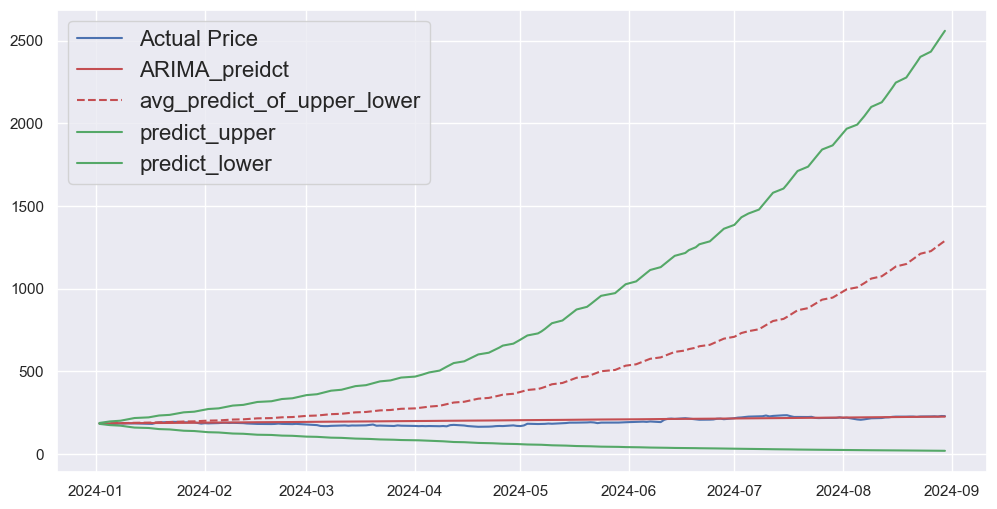

In [38]:
plt.figure(figsize=(12,6))

plt.plot(test_data['Close'], color = 'b')
plt.plot(test_data['preidct'], color = 'r')
plt.plot(test_data['avg_predict'], color = 'r', linestyle='dashed')
plt.plot(test_data['predict_upper'], color = 'g')
plt.plot(test_data['predict_lower'], color = 'g')


plt.legend(('Actual Price', 'ARIMA_preidct', 'avg_predict_of_upper_lower', 'predict_upper', 'predict_lower'), fontsize=16)

The above graph shows that in the initial stages of prediction, the forecast interval is narrower, and both predicted price values are not far from the actual price. However, as the prediction time extends further into the future, the forecast interval widens and the mean price within the interval shifts, making it difficult to accurately assess the model's effectiveness.

In [39]:
new_date = test_data.index.get_level_values('Date') <= '2024-05-01'

new_test = test_data[new_date]

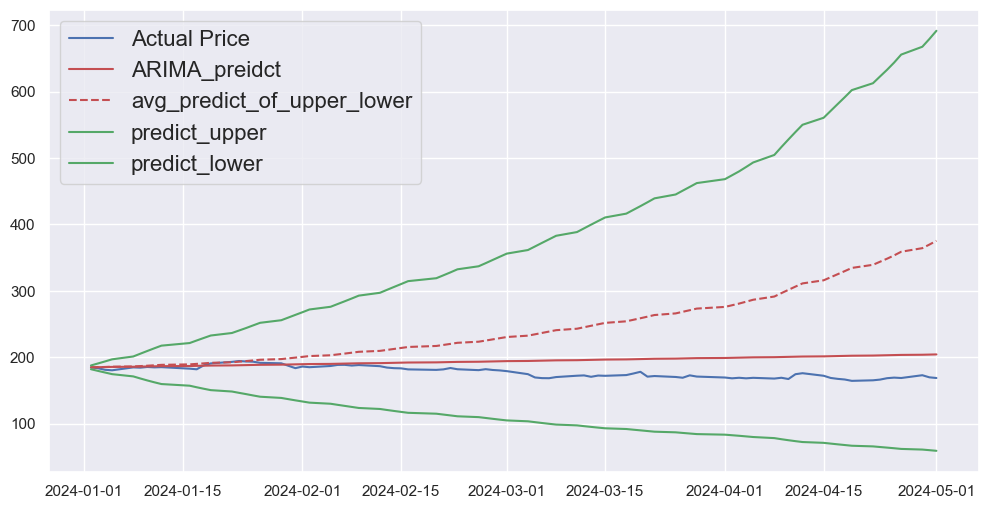

In [40]:
plt.figure(figsize=(12,6))

plt.plot(new_test['Close'], color = 'b')
plt.plot(new_test['preidct'], color = 'r')
plt.plot(new_test['avg_predict'], color = 'r', linestyle='dashed')
plt.plot(new_test['predict_upper'], color = 'g')
plt.plot(new_test['predict_lower'], color = 'g')


plt.legend(('Actual Price', 'ARIMA_preidct', 'avg_predict_of_upper_lower', 'predict_upper', 'predict_lower'), fontsize=16)

Initial accuracy: The model performs well in the short term, with narrow prediction intervals and predictions close to actual values. As the forecast horizon extends, the prediction intervals widen, indicating growing uncertainty. Over a two-month period, the differences between predicted and actual values become more noticeable.